In [7]:
#Imports 

import numpy as np 
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

### MULTI MODEL TRAINING

## 1. Fitness Checking model
  - Model used for training  used is RandomForestClassifier

Confusion Matrix:
 [[8 0]
 [0 7]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



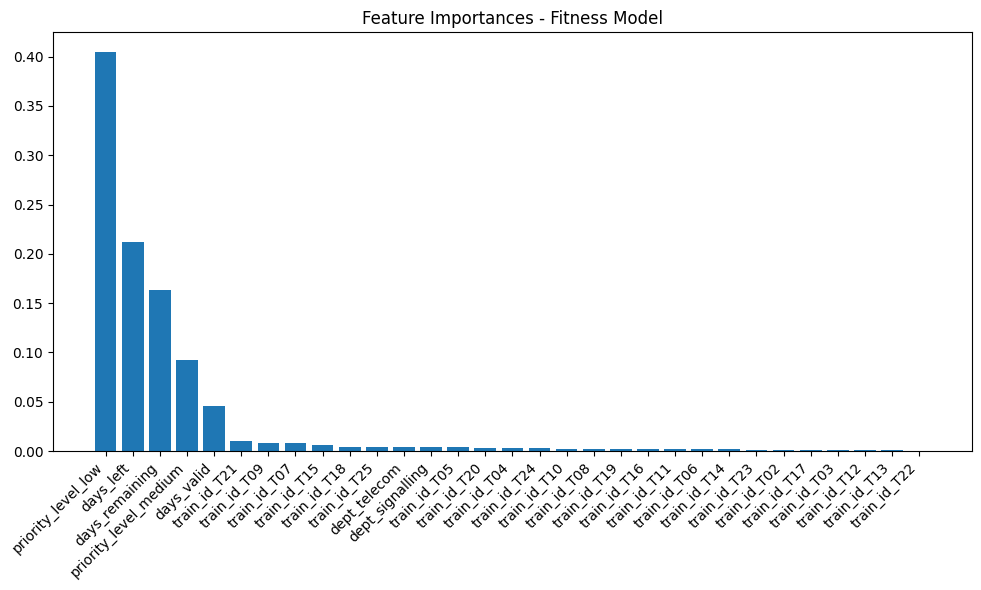

Model saved as fitness_model.pkl


In [8]:
# 1. Load dataset
df = pd.read_csv("../data/training/fitness.csv")

# 2. Drop noise columns
df= df.drop(columns=["inspector_name", "notes"], errors="ignore")


# 4. Convert dates to numeric features (days since issued, days until valid)
df["issued_on"] = pd.to_datetime(df["issued_on"], errors="coerce")
df["valid_until"] = pd.to_datetime(df["valid_until"], errors="coerce")

df["days_valid"] = (df["valid_until"] - df["issued_on"]).dt.days
df["days_remaining"] = (df["valid_until"] - pd.Timestamp.today()).dt.days

# Drop original date columns
df = df.drop(columns=["issued_on", "valid_until"], errors="ignore")

# 5. Handle categorical variables
df = pd.get_dummies(df, drop_first=True)

# 6. Split features/target
X = df.drop(columns=["status"])
y = df["status"]

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Train Random Forest Classifier
model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# 9. Predictions & evaluation
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 10. Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45, ha="right")
plt.title("Feature Importances - Fitness Model")
plt.tight_layout()
plt.show()

# 11. Save model
joblib.dump(model, "../src/engine/model/fitness_model.pkl")
print("Model saved as fitness_model.pkl")


## Maintenance
- Model used for the Training is XGBoostClassifier.

/home/arunthakur/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[ 8 10]
 [ 7 23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.44      0.48        18
           1       0.70      0.77      0.73        30

    accuracy                           0.65        48
   macro avg       0.62      0.61      0.61        48
weighted avg       0.64      0.65      0.64        48



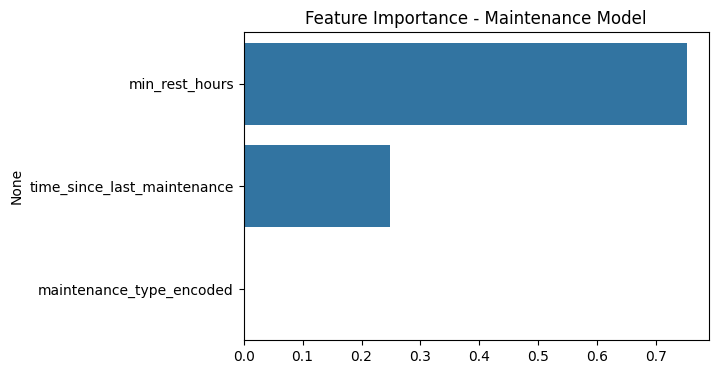

Maintenance model saved as maintenance_model.pkl


In [10]:

# --- Load dataset ---
df = pd.read_csv("../data/training/maintenance.csv")

# --- Map target column (status) ---
df["target"] = df["status"].map({"overdue":0,"resting": 0, "ready": 1})

# --- Feature engineering ---
# Convert last_maintenance_time to datetime
df["last_maintenance_time"] = pd.to_datetime(df["last_maintenance_time"], errors="coerce")

# Assume current reference time = max timestamp in dataset
current_time = df["last_maintenance_time"].max()
df["time_since_last_maintenance"] = (current_time - df["last_maintenance_time"]).dt.total_seconds() / 3600  # hours

# Encode maintenance_type (categorical)
le = LabelEncoder()
df["maintenance_type_encoded"] = le.fit_transform(df["maintenance_type"])

# --- Drop unnecessary columns ---
df = df.drop(columns=["train_id", "status", "last_maintenance_time", "maintenance_type"])

# --- Split features/target ---
X = df.drop(columns=["target"])
y = df["target"]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Train XGBoost model ---
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X_train, y_train)

# --- Evaluation ---
y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Feature importance ---
plt.figure(figsize=(6,4))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importance - Maintenance Model")
plt.show()

# --- Save model ---
joblib.dump(model, "../src/engine/model/maintenance_model.pkl")
print("Maintenance model saved as maintenance_model.pkl")